In [1]:
import os,sys
import torch
import torchvision
import argparse
import tqdm
import random
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F2
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from datasets import *
from utils import *
from torchvision.models.feature_extraction import create_feature_extractor

/home/yunjae_heo/anaconda3/envs/hyj_sam/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import cv2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '6'

In [3]:
dpath = '/ailab_mat/dataset/ISIC_skin_disease'
# dpath = '/ailab_mat/dataset/ILSVRC/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def gen_cam(feat, weight):
    pass

In [6]:
testset = ISIC2017(dpath, 'Test', None)
testloader = DataLoader(testset, 1, shuffle=False, num_workers=4)

model = models.resnet18()
model.fc = nn.Linear(512, 30)

return_nodes = {
            'layer1':'l1',
            'layer2':'l2',
            'layer3':'l3',
            'layer4':'l4',
            'fc':'fc'
        }
model = create_feature_extractor(model, return_nodes=return_nodes)
model = model.to(device)

model.load_state_dict(torch.load('/ailab_mat/personal/heo_yunjae/supervision_active_learning/ask_for_help/parameters/ilsvrc/seed0/baseline/ACC_65.93.pth'))

criterion = nn.CrossEntropyLoss()

In [7]:
model.eval()
i = 0
for inputs, labels, masks in testloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs, 1)
    if pred != labels:
        img = F2.to_pil_image(inputs[0])
        mask = F2.to_pil_image(masks[0])
        img.save(f'./pictures/image{i}.jpg')
        mask.save(f'./pictures/mask{i}.jpg')
        i += 1

In [8]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F2.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

(0.0, 133.18775431650033, 105.12156524719315)
torch.Size([3, 224, 224])
tensor([[ 67.,  76., 141., 190.]])


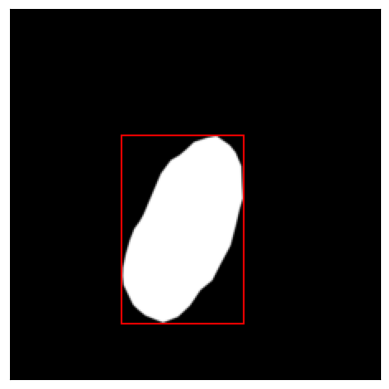

In [14]:
inputs, _, mask = testset[1]
np_mask = mask.numpy()

from scipy import ndimage
com = ndimage.center_of_mass(np_mask)
print(com)

masked_input = inputs * mask
print(masked_input.shape)

from torchvision.ops import masks_to_boxes

boxes = masks_to_boxes(mask)
print(boxes)
from torchvision.utils import draw_bounding_boxes

boxes = boxes.type(torch.uint8)
mask = (mask*255).type(torch.uint8)
mask_with_box = draw_bounding_boxes(mask, boxes, colors="red")
# mask_with_box = (mask_with_box*255).type(torch.uint8)
show(mask_with_box)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 114, 74])


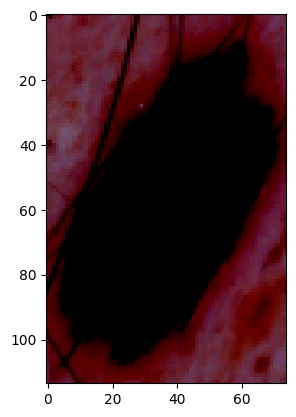

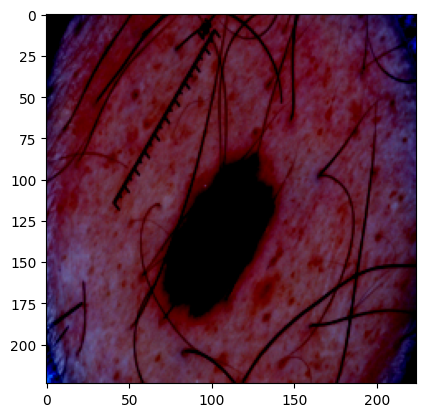

In [25]:
croped_img = F2.crop(inputs, boxes[0][1],boxes[0][0],boxes[0][3]-boxes[0][1],boxes[0][2]-boxes[0][0])
print(croped_img.shape)

plt.figure()
plt.imshow(croped_img.permute(1,2,0))

background = torch.zeros_like(inputs)
background[:,boxes[0][1]:boxes[0][3],boxes[0][0]:boxes[0][2]] = croped_img
# print(background[:,boxes[0][0]:boxes[0][2],boxes[0][1]:boxes[0][3]].shape)
plt.figure()
plt.imshow(inputs.permute(1,2,0))
# plt.imshow(background.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


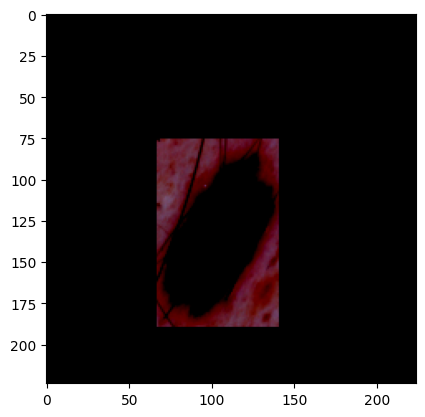

In [26]:
plt.figure()
plt.imshow(background.permute(1,2,0))

In [39]:
import torchvision.models as models
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

model = models.resnet18()
train_nodes, eval_nodes = get_graph_node_names(models.resnet18())
print(train_nodes)
return_nodes = {
    'layer1':'layer1',
    'layer2':'layer2',
    'layer3':'layer3',
    'layer4':'layer4',
    'fc':'fc'
}
body = create_feature_extractor(model, return_nodes=return_nodes)

import torch
x = torch.randn([2,3,224,224])
out = body(x)
print(type(out))
# print(out['fc'].shape)

['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.add', 'layer1.0.relu_1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.add', 'layer1.1.relu_1', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.0.add', 'layer2.0.relu_1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer2.1.add', 'layer2.1.relu_1', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample.0', 'layer3.0.downsample.1', 'layer3.0.add', 'layer3.0.relu_1', 'layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 'layer3.1.bn2', 'layer3.1.add', 'layer3.1.relu_1', 'layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 'layer4.0.downsample.0', 'layer4.0.downsample.1', 'lay

In [82]:
import torch

a = torch.tensor([[1.0,2.0],[3.0,4.0],[5.0,6.0]])
b = -1*torch.log(torch.softmax(a, dim=-1))*(torch.softmax(a, dim=-1))
c = torch.sum(b, dim=-1)
print(c.shape)
print(torch.min(c))
print(torch.max(c))

torch.Size([3])
tensor(0.5822)
tensor(0.5822)


In [58]:
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torch

x = torch.tensor([1,2,3,4])
loader = DataLoader(x, batch_size=1)

iter1 = iter(loader)

print(next(iter1))
print(next(iter1))

tensor([1])
tensor([2])


In [63]:
import torch
a = torch.tensor([1.0,2.0,3.0])
a.mean()

tensor(2.)